## AirQualityUCI.csv
To predict Total Nitrogen Oxides (NOx)
```
Date;Time;CO(GT);PT08.S1(CO);NMHC(GT);C6H6(GT);PT08.S2(NMHC);NOx(GT);PT08.S3(NOx);NO2(GT);PT08.S4(NO2);PT08.S5(O3);T;RH;AH;;
10/03/2004;18.00.00;2,6;1360;150;11,9;1046;166;1056;113;1692;1268;13,6;48,9;0,7578;;
10/03/2004;19.00.00;2;1292;112;9,4;955;103;1174;92;1559;972;13,3;47,7;0,7255;;
10/03/2004;20.00.00;2,2;1402;88;9,0;939;131;1140;114;1555;1074;11,9;54,0;0,7502;;
10/03/2004;21.00.00;2,2;1376;80;9,2;948;172;1092;122;1584;1203;11,0;60,0;0,7867;;
10/03/2004;22.00.00;1,6;1272;51;6,5;836;131;1205;116;1490;1110;11,2;59,6;0,7888;;
10/03/2004;23.00.00;1,2;1197;38;4,7;750;89;1337;96;1393;949;11,2;59,2;0,7848;;
11/03/2004;00.00.00;1,2;1185;31;3,6;690;62;1462;77;1333;733;11,3;56,8;0,7603;;

```
https://archive.ics.uci.edu/dataset/360/air+quality

In [ ]:
# import libraries
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

# load the dataset
file_path = '/content/gdrive/My Drive/DL_data/airQualityUCI/AirQualityUCI.csv'
data = pd.read_csv(file_path, delimiter=';')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# clean numeric columns
columns_to_clean = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # origianl article did not include CO(GT)

# replace commas with dots and convert them to numeric
for col in columns_to_clean:
    data[col] = data[col].str.replace(',', '.')
    data[col] = pd.to_numeric(data[col], errors='coerce')

# drop the unnamed columns and any rows with missing values
data_cleaned = data.drop(columns=['Unnamed: 15', 'Unnamed: 16']).dropna()

# convert 'Date' and 'Time' to a single DateTime index <=== Not a colum!!!
data_cleaned['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S')
data_cleaned = data_cleaned.set_index('DateTime')

# drop the 'Date' and 'Time' columns
data_cleaned = data_cleaned.drop(columns=['Date', 'Time'])

# ensure all columns are numeric
data_cleaned = data_cleaned.apply(pd.to_numeric, errors='coerce')

# drop rows with NaN
data_cleaned = data_cleaned.dropna()

# split the data (80% train, 20% test)
train_size = int(len(data_cleaned) * 0.8)
train_data = data_cleaned[:train_size]
test_data = data_cleaned[train_size:]

In [ ]:
print(train_data.head(10))
print(train_data.shape)
#train_data.iloc[0]
print(train_data.tail(10))

                     CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
DateTime                                                                      
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   
2004-03-10 23:00:00     1.2       1197.0      38.0       4.7          750.0   
2004-03-11 00:00:00     1.2       1185.0      31.0       3.6          690.0   
2004-03-11 01:00:00     1.0       1136.0      31.0       3.3          672.0   
2004-03-11 02:00:00     0.9       1094.0      24.0       2.3          609.0   
2004-03-11 03:00:00     0.6       1010.0      19.0       1.7          561.0   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)

In [ ]:
# data preparation
n_lags = 3

def create_lagged_features_lstm(data, n_lags):
    lagged_data = data.copy()
    for i in range(1, n_lags + 1):
        lagged_data[f'NOx_lag_{i}'] = lagged_data['NOx(GT)'].shift(i)
    lagged_data = lagged_data.dropna() # drop any rows with missing values
    return lagged_data

# apply lagged feature generation to train_data and test_data
train_data_lagged = create_lagged_features_lstm(train_data, n_lags)
test_data_lagged = create_lagged_features_lstm(test_data, n_lags)

print(train_data_lagged.iloc[0])
print(train_data_lagged.shape)
# print(test_data_lagged.head())
print(test_data_lagged.shape)

CO(GT)              2.2000
PT08.S1(CO)      1376.0000
NMHC(GT)           80.0000
C6H6(GT)            9.2000
PT08.S2(NMHC)     948.0000
NOx(GT)           172.0000
PT08.S3(NOx)     1092.0000
NO2(GT)           122.0000
PT08.S4(NO2)     1584.0000
PT08.S5(O3)      1203.0000
T                  11.0000
RH                 60.0000
AH                  0.7867
NOx_lag_1         131.0000
NOx_lag_2         103.0000
NOx_lag_3         166.0000
Name: 2004-03-10 21:00:00, dtype: float64
(7482, 16)
(1869, 16)


In [ ]:
# separate X and y
X_train_all_features = train_data_lagged.drop(columns=['NOx(GT)']).values  # Use all features
y_train = train_data_lagged['NOx(GT)'].values
print(X_train_all_features.shape)
print(y_train.shape)
print(y_train[0:5])
print(y_train[-5:])

X_test_all_features = test_data_lagged.drop(columns=['NOx(GT)']).values
y_test = test_data_lagged['NOx(GT)'].values

# reshape data for LSTM (samples, timesteps, features)
# //  <--- floor division
X_train_lstm_all_features = X_train_all_features.reshape((X_train_all_features.shape[0], n_lags, X_train_all_features.shape[1] // n_lags))
X_test_lstm_all_features = X_test_all_features.reshape((X_test_all_features.shape[0], n_lags, X_test_all_features.shape[1] // n_lags))

print(X_train_lstm_all_features.shape)
print(X_test_lstm_all_features.shape)
print(X_train_lstm_all_features[0:5])
print(X_train_lstm_all_features[-5:])


(7482, 15)
(7482,)
[172. 131.  89.  62.  62.]
[172. 138. 121. 143. 114.]
(7482, 3, 5)
(1869, 3, 5)
[[[2.200e+00 1.376e+03 8.000e+01 9.200e+00 9.480e+02]
  [1.092e+03 1.220e+02 1.584e+03 1.203e+03 1.100e+01]
  [6.000e+01 7.867e-01 1.310e+02 1.030e+02 1.660e+02]]

 [[1.600e+00 1.272e+03 5.100e+01 6.500e+00 8.360e+02]
  [1.205e+03 1.160e+02 1.490e+03 1.110e+03 1.120e+01]
  [5.960e+01 7.888e-01 1.720e+02 1.310e+02 1.030e+02]]

 [[1.200e+00 1.197e+03 3.800e+01 4.700e+00 7.500e+02]
  [1.337e+03 9.600e+01 1.393e+03 9.490e+02 1.120e+01]
  [5.920e+01 7.848e-01 1.310e+02 1.720e+02 1.310e+02]]

 [[1.200e+00 1.185e+03 3.100e+01 3.600e+00 6.900e+02]
  [1.462e+03 7.700e+01 1.333e+03 7.330e+02 1.130e+01]
  [5.680e+01 7.603e-01 8.900e+01 1.310e+02 1.720e+02]]

 [[1.000e+00 1.136e+03 3.100e+01 3.300e+00 6.720e+02]
  [1.453e+03 7.600e+01 1.333e+03 7.300e+02 1.070e+01]
  [6.000e+01 7.702e-01 6.200e+01 8.900e+01 1.310e+02]]]
[[[ 1.000e+00  8.410e+02 -2.000e+02  2.600e+00  6.250e+02]
  [ 1.054e+03  1.120e+

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 23213.6191 - val_loss: 12491.4922
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7418.2168 - val_loss: 11596.7930
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5646.7910 - val_loss: 9306.7178
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4414.9146 - val_loss: 7759.8896
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4140.6787 - val_loss: 7119.0327
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4232.2832 - val_loss: 7559.9780
Epoch 7/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3435.4194 - val_loss: 9963.2588
Epoch 8/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3558.3003 - val_loss: 10913.9209
Epoch 9/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3792.8342 - val_loss: 10512.1797
Epoch 10/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3570.7661 - val_loss: 7442.8809
Epoch 11/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3257.9075 - va

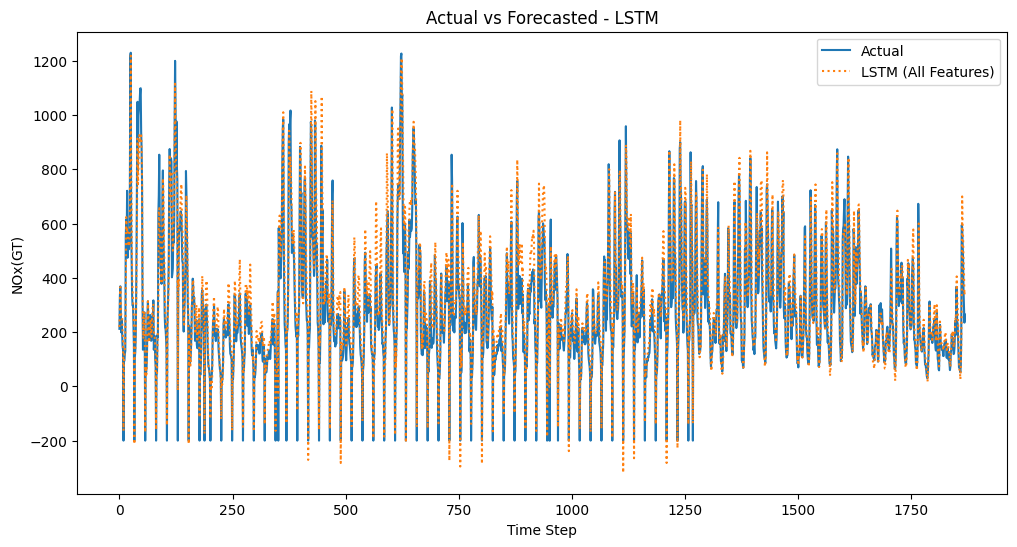

In [ ]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# build the model
model_all_features = Sequential()
model_all_features.add(LSTM(50, activation='relu', input_shape=(n_lags, X_train_lstm_all_features.shape[2]))) # 3, 5
model_all_features.add(Dense(1))
model_all_features.compile(optimizer='adam', loss='mse')

# add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train
history_all_features = model_all_features.fit(X_train_lstm_all_features, y_train, epochs=100, batch_size=32, validation_data=(X_test_lstm_all_features, y_test), callbacks=[early_stopping], verbose=1)

# forecast
y_pred_all_features = model_all_features.predict(X_test_lstm_all_features)

# evaluate
rmse_all_features = np.sqrt(mean_squared_error(y_test, y_pred_all_features))
print(f'Root Mean Squared Error (RMSE): {rmse_all_features}')

loss = model_all_features.evaluate(X_test_lstm_all_features, y_test, verbose=0)
print(f'RMSE calculated from m.evaluate: {np.sqrt(loss)}')

# visualize
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_all_features, label='LSTM (All Features)', linestyle=':')
plt.title('Actual vs Forecasted - LSTM')
plt.xlabel('Time Step')
plt.ylabel('NOx(GT)')
plt.legend()
plt.show()

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 23820.1973 - val_loss: 12328.2100
Epoch 2/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8847.3623 - val_loss: 9437.7324
Epoch 3/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7148.4707 - val_loss: 6983.9834
Epoch 4/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5641.4409 - val_loss: 5950.2271
Epoch 5/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4670.7871 - val_loss: 6232.4351
Epoch 6/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3853.8762 - val_loss: 5683.6133
Epoch 7/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3981.6145 - val_loss: 5178.2979
Epoch 8/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3831.6262 - val_loss: 7549.9780
Epoch 9/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3372.2422 - val_loss: 5865.6797
Epoch 10/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3398.4612 - val_loss: 8571.2783
Epoch 11/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3715.0283 - val_l

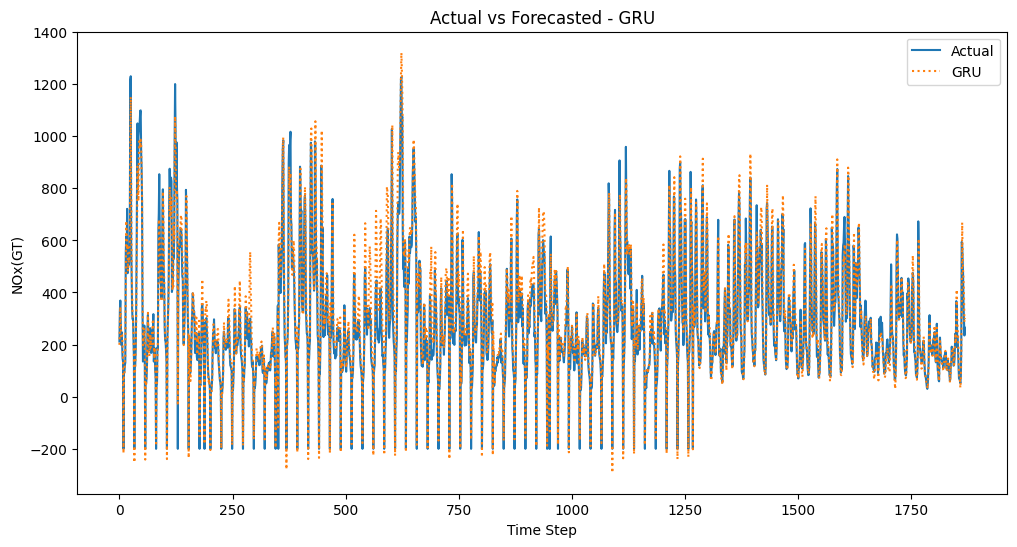

In [ ]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# data prep
def create_lagged_features_gru(data, n_lags):
    lagged_data = data.copy()
    for i in range(1, n_lags + 1):
        lagged_data[f'NOx_lag_{i}'] = lagged_data['NOx(GT)'].shift(i)
    lagged_data = lagged_data.dropna()
    return lagged_data

n_lags = 3

# apply lagged feature generation to train and test
train_data_lagged = create_lagged_features_gru(train_data, n_lags)
test_data_lagged = create_lagged_features_gru(test_data, n_lags)

# separate out X and y
X_train_all_features = train_data_lagged.drop(columns=['NOx(GT)']).values
y_train = train_data_lagged['NOx(GT)'].values

X_test_all_features = test_data_lagged.drop(columns=['NOx(GT)']).values
y_test = test_data_lagged['NOx(GT)'].values

# reshape data for GRU (samples, timesteps, features)
X_train_gru_all_features = X_train_all_features.reshape((X_train_all_features.shape[0], n_lags, X_train_all_features.shape[1] // n_lags))
X_test_gru_all_features = X_test_all_features.reshape((X_test_all_features.shape[0], n_lags, X_test_all_features.shape[1] // n_lags))

# build GRU
model_gru_all_features = Sequential()
model_gru_all_features.add(GRU(60, activation='relu', input_shape=(n_lags, X_train_gru_all_features.shape[2])))
model_gru_all_features.add(Dense(1))  # Output layer predicting one value (NOx(GT))
model_gru_all_features.compile(optimizer='adam', loss='mse')

# add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train
history_gru_all_features = model_gru_all_features.fit(X_train_gru_all_features, y_train, epochs=150, batch_size=32, validation_data=(X_test_gru_all_features, y_test), callbacks=[early_stopping], verbose=1)

# forecast
y_pred_gru_all_features = model_gru_all_features.predict(X_test_gru_all_features)

# evaluate
rmse_gru_all_features = np.sqrt(mean_squared_error(y_test, y_pred_gru_all_features))
print(f'Root Mean Squared Error (RMSE) for GRU (All Features): {rmse_gru_all_features}')

# visualize
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_gru_all_features, label='GRU', linestyle=':')
plt.title('Actual vs Forecasted - GRU')
plt.xlabel('Time Step')
plt.ylabel('NOx(GT)')
plt.legend()
plt.show()

In [ ]:
# dataframe shift() test
import pandas as pd

df = pd.DataFrame({'A': [1, 2, 3, 4], 'B': [5, 6, 7, 8], 'C': [9, 0, 1, 2]})
print(df)
# Shift the data down by 1 row
df_shifted_down = df.shift(1)
print(df_shifted_down)

   A  B  C
0  1  5  9
1  2  6  0
2  3  7  1
3  4  8  2
     A    B    C
0  NaN  NaN  NaN
1  1.0  5.0  9.0
2  2.0  6.0  0.0
3  3.0  7.0  1.0


In [ ]:
n = 2
df = pd.DataFrame({'A': [1, 2, 3, 4], 'B': [5, 6, 7, 8], 'C': [9, 0, 1, 2]})
for i in range(1, n + 1):
    df[f'lag_{i}'] = df['B'].shift(i)
df_shifted_down = df.shift(1)
print(df_shifted_down)

     A    B    C  lag_1  lag_2
0  NaN  NaN  NaN    NaN    NaN
1  1.0  5.0  9.0    NaN    NaN
2  2.0  6.0  0.0    5.0    NaN
3  3.0  7.0  1.0    6.0    5.0
